In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Atsisiunciame duomenis ( pvz . NVDA ir BTC )
tickers = ["BNB-USD", "DOGE-USD"]
df = yf.download(tickers, start="2018-01-01")
returns = df["Close"].pct_change().dropna()


[*********************100%***********************]  2 of 2 completed


In [9]:
print(returns)
print()
print(returns.mean())

Ticker       BNB-USD  DOGE-USD
Date                          
2018-01-02  0.050289  0.026490
2018-01-03  0.078992  0.019136
2018-01-04 -0.033756  0.034764
2018-01-05  0.618973  0.261613
2018-01-06  0.525742  0.221583
...              ...       ...
2026-02-17 -0.014378 -0.003476
2026-02-18 -0.021112 -0.021047
2026-02-19  0.004361 -0.002264
2026-02-20  0.030476  0.018649
2026-02-21  0.003784 -0.000672

[2973 rows x 2 columns]

Ticker
BNB-USD     0.002606
DOGE-USD    0.003388
dtype: float64


BNB-USD


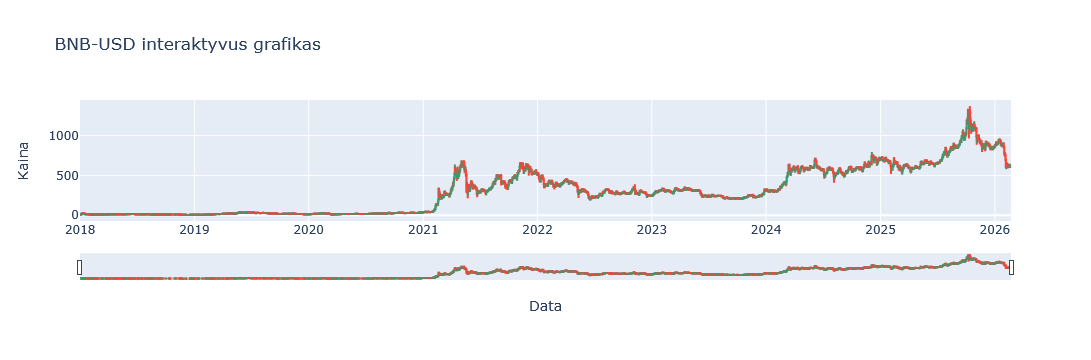

0.0026063622050873318
Šarpo santykis: 0.98 
DOGE-USD


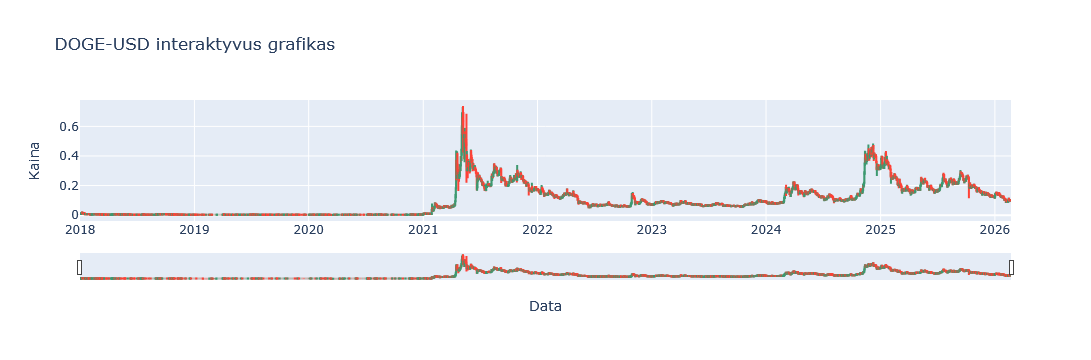

0.0033880596357366813
Šarpo santykis: 0.69 


In [18]:
risk_free_rate = 0.03  # Tarkime , JAV obligaciju palukanos 3%


def analyze_asset(df):
    """
    Kainos grafiką su indikatoriumi. - Candlestick
    95% VaR reikšmę.
    Expected Shortfall
    Sharpe koeficientą.
    """

    for ticker in tickers:
        print(ticker)

        df_plot = df

        if isinstance(df_plot.columns, pd.MultiIndex):
            df_plot = df_plot.xs(ticker, axis=1, level=1)

        fig = go.Figure(
            data=[
                go.Candlestick(
                    x=df_plot.index,
                    open=df_plot["Open"],
                    high=df_plot["High"],
                    low=df_plot["Low"],
                    close=df_plot["Close"],
                    name="Market Data",
                )
            ]
        )
        fig.update_layout(
            title=f"{ticker} interaktyvus grafikas",
            yaxis_title="Kaina",
            xaxis_title="Data",
        )
        fig.show()

        returns = df["Close"][ticker].pct_change().dropna()
        print(returns.mean())

        if "-USD" in ticker: # Jeigu kriptovaliuta, tuomet prekyba vyksta visus metus
            annual_return = returns.mean() * 365
            annual_std = returns.std() * np.sqrt(365)
        else:
            annual_return = returns.mean() * 252
            annual_std = returns.std() * np.sqrt(252)

        sharpe_ratio = (annual_return - risk_free_rate) / annual_std
        print(f"Šarpo rodiklis: { sharpe_ratio :.2f} ")


analyze_asset(df)
